# Modeling

Julian Domingo - jad5348

This file contains my process for training my base learners and meta learner to predict the probability values for the target value **Y**.

In [181]:
# Computation / Data Analysis stuff
import numpy as np
import pandas as pd
from scipy.stats import skew, probplot, norm
from scipy.special import boxcox1p

# Modeling stuff
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import (GridSearchCV, 
                                     StratifiedKFold,
                                     cross_val_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              ExtraTreesClassifier,
                              BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, KFold

# Plotting stuff
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pandas.tools.plotting import scatter_matrix

# Plotting visuals stuff
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

# ignore warnings (i.e. deprecation warnings)
import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [171]:
test_ids = pd.read_csv("./data/raw/test.csv")[["id"]]
train_y_cp = pd.read_csv("./data/raw/train.csv")["Y"]

## Helper Functions

In [152]:
def get_data(filename):
    train = pd.read_csv("./data/refined/train/train_{}.csv".format(filename))
    test = pd.read_csv("./data/refined/test/test_{}.csv".format(filename))
    
    x_train = train.drop(["Y"], axis = 1)
    y_train = train["Y"]
    
    return train, test, x_train, y_train

In [153]:
train_raw, test_raw, x_train_raw, y_train_raw = get_data("raw")
train_base, test_base, x_train_base, y_train_base = get_data("base")
train_log, test_log, x_train_log, y_train_log = get_data("log")
train_scaled, test_scaled, x_train_scaled, y_train_scaled = get_data("scaled")

## Modeling Functions

In [94]:
# Obtain fold indices for base learner training.
n_splits = 5
folds = list(StratifiedKFold(n_splits, random_state=seed).split(x_train_base, y_train_base))

Note that we want to use the **same** fold indices every time to reduce overfitting. 

# Base Learners

### Random Forest Classifier

Tuning parameters
    * n_estimators (online): "n_estimators is not really worth optimizing. The more estimators you give it, the better it will do. 500 or 1000 is usually sufficient." -- stack overflow
    * criterion (class): Constantine mentioned entropy is the preferred criterion for Random Forests.
    * max_features (code): used GridSearchCV, sci-kit learn docs showed [1, 3, 10] as good contenders.
    * max_depth (observation): It seems like limiting the max depth of the classifier inhibits on the predictive capabilities, as my submission with default max_depth produced a higher public leaderboard score. (~0.1 higher)

In [95]:
rfc_param_grid = {
    "max_features": [1, 3, 10]
}

rfc = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1)

gs_rfc = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=n_splits, scoring="roc_auc")
gs_rfc.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 3, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [135]:
# So, we'll use 10 to be our max_features value.
print gs_rfc.best_params_

{'max_features': 10}


In [130]:
# Train with our optimized parameters.
rfc = RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=1000, n_jobs=-1)
rfc = train_and_save_base_learner_preds(rfc, folds, x_train_base, y_train_base, test_base, "random_forest_base")
rf_cv = get_cross_val_score(rfc, x_train_base, y_train_base, n_splits)

Cross validation score: 0.767653985688 +/- 0.0137592880393
Raw scores: [ 0.76729217  0.78474473  0.74785336  0.7578412   0.78053847]


In [131]:
# Finally, predict our probabilities.
rfc.fit(x_train_base, y_train_base)
rfc_probs = rfc.predict_proba(test_base)[:,1]
print rfc_probs

[ 0.971  0.684  0.929 ...,  0.862  0.987  0.968]


In [132]:
# save a copy of the predictions
submission = pd.DataFrame({"id": test_ids.id, "Y": rfc_probs})
submission.to_csv("./submissions/random_forest_lone.csv", index=False, columns=["id", "Y"])

Let's see what features RandomForestClassifier deemed most important.

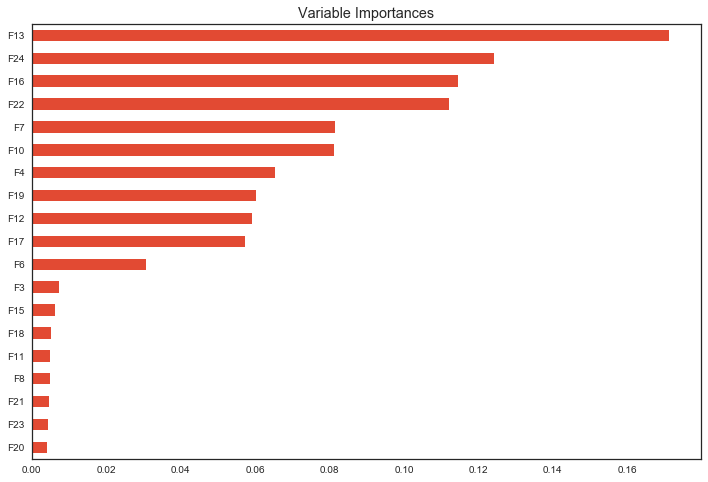

In [127]:
pd.Series(index=x_train_base.columns, data=rfc.feature_importances_).sort_values().plot(kind='barh', title='Variable Importances')

Thus, we'll use the top 2 features, **F13** and **F24**, to use in our PolynomialFeature transformed data set. Generation of this data set can be found in **"data_processing.ipynb"** under the "Transformations" subsection.

### Logistic Regressor

Tuning Parameters
    * solver (online): according to docs, "For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and 
        ‘saga’ are faster for large ones."
    * tol (observation): with the default being 1e-4, I decided giving a little leeway in both directions would be good to observe.
    * C (online): according to sklearn, "Large values of C give more freedom to the model. Conversely, smaller values of C constrain the model more."

In [137]:
lr_param_grid = {
    "tol": [1e-5, 1e-4, 1e-3],
    "solver": ["liblinear", "sag"], # For some reason, "saga" isn't allowed anymore.
    "C": [0.01, 0.1, 1.0, 10, 100] # Inverse of regularization strength. Smaller values specify stronger regularization (must be pos float)
}

lr = LogisticRegression()

gs_lr = GridSearchCV(estimator=lr, param_grid=lr_param_grid, cv=n_splits, scoring="roc_auc")
gs_lr.fit(x_train_log, y_train_log)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1.0, 10, 100], 'tol': [1e-05, 0.0001, 0.001], 'solver': ['liblinear', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [140]:
print gs_lr.best_params_
print gs_lr.best_score_

{'C': 100, 'tol': 1e-05, 'solver': 'liblinear'}
0.545830385785


In [156]:
# Train with our optimized parameters.
lr = LogisticRegression(C=100, tol=1e-05, solver="liblinear")
lr = train_and_save_base_learner_preds(lr, folds, x_train_log, y_train_log, test_log, "logistic_regression_log")
lr_cv = get_cross_val_score(lr, x_train_log, y_train_log, n_splits)

Cross validation score: 0.545833322926 +/- 0.0230976755653
Raw scores: [ 0.56433684  0.55349304  0.50612     0.53532381  0.56989291]


In [157]:
# Finally, predict our probabilities.
lr.fit(x_train_log, y_train_log)
lr_probs = lr.predict_proba(test_log)[:,1]
print lr_probs

[ 0.91999531  0.93921733  0.91854823 ...,  0.92974219  0.92594105
  0.94791889]


In [158]:
# save a copy of the predictions
submission = pd.DataFrame({"id": test_ids.id, "Y": lr_probs})
submission.to_csv("./submissions/logistic_regression_lone.csv", index=False, columns=["id", "Y"])

The logistic regressor scores are pretty bad, both in offline CV and when submitted to Kaggle. I'll choose to leave this base learner out of my ensemble.

### XGBoost

Tuning Parameters: all values were picked with guidance from the following article: "https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/"

For XGBoost, I'll train several instances of the model on different transforms of the data set:
    * With base data
    * With polynomial features
    * Bagged classifier (using XGB as base learner, fitted with base data)

###### Step 1: Optimize learning_rate & n_estimators
1. max_depth = 5 : This should be between 3-10. I’ve started with 5.
2. min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
3. gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
4. subsample & colsample_bytree = 0.8 : This is a commonly used start value. Typical values range between 0.5-0.9.
5. scale_pos_weight = 1: Because of high class imbalance

In [201]:
def model_fit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, train_y_cp)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], train_y_cp, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : {}".format(metrics.accuracy_score(train_y_cp, dtrain_predictions)))
    print ("AUC Score (Train): {}".format(metrics.roc_auc_score(train_y_cp, dtrain_predprob)))
    # .get_booster().get_score(importance_type='weight')
    # feat_imp = pd.Series(alg._Booster().get_fscore()).sort_values(ascending=False)
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type="weight")).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.958859793689
AUC Score (Train): 0.983245677822


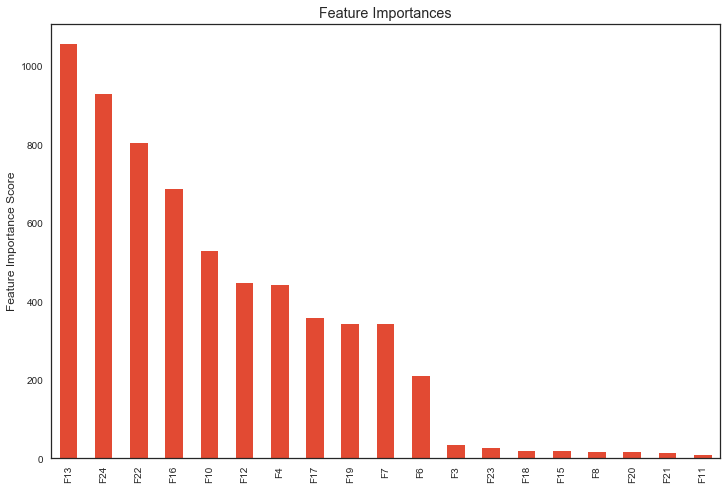

In [202]:
# Initial xgb parameters
xgb_base_grid = {
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 5,
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": 'binary:logistic', # Used for classifier XGB
    "nthread": 4,
    "scale_pos_weight": 1,
    "seed": seed
}

xgb_base = XGBClassifier(**xgb_base_grid)
model_fit(xgb_base, x_train_base, x_train_base.columns.values)

# gs_xgb_base = GridSearchCV(estimator=xgb_base, param_grid=xgb_base_grid, cv=n_splits, scoring="roc_auc")

In [161]:
# Tune BaggedClassifier parameters
# xgb_bag = BaggingClassifier(estimator=xgb, 